In [149]:
# 04_log_prediction

In [150]:
# Force to reload extrernal modules every new cell execution
%reload_ext autoreload
%autoreload 2

In [151]:
### IMPORT ###
from pathlib import Path
from datetime import datetime
import pandas as pd
import re
# plot
import matplotlib.pyplot as plt
# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from xgboost import XGBRegressor
# XAI
import shap


In [152]:
### LOCAL IMPORT ###
from config import config_reader
from utilities import extract_files, convert_seconds_to_hours

In [153]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")

dic_types = {"CaseID":object,  "TIMESTAMP":object, "ESI": int, "CASE_DURATION_sec": float, "REMAINING_TIME_sec":float} # <-- INPUT: columns types

encoding_dir = str(yaml_config["LOG_ENCODING_DIR"]) # <-- INPUT: the directory with files encoded for the ML models

# ML
ml_dir = str(yaml_config["ML_DIR"]) # <-- INPUT: the directoryin which to save ML results
label_column = "REMAINING_TIME_sec" # <-- INPUT: label for prediction
drop_column = ["CaseID", "TIMESTAMP"]  # <-- INPUT: columns to drop
cv_folds = 5 # <-- INPUT: number of folds for Cross Validation

# FUNCTIONS

In [154]:
def plot_custom_distribution(dataframe: pd.DataFrame, x_column: str, y_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color='skyblue')
    plt.title(f'Distribution of {y_column} by {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [155]:
def plot_custom_distribution_with_colours(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]
    encoding_values = dataframe[encoding_column]

    # Create a colour map
    colours = encoding_values.map({'B': 'skyblue', 'F': 'lightgreen'})

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color=colours)
    plt_title = f"Distribution of '{y_column}' by '{x_column}'"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(handles=[
        plt.Line2D([0], [0], color='skyblue', lw=4, label='B'),
        plt.Line2D([0], [0], color='lightgreen', lw=4, label='F')
    ], title=encoding_column)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [156]:
def plot_custom_distribution_side_by_side(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str, model_name:str) -> None:
    """
    This function takes a dataframe as input and displays a side-by-side bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    model_name (str): The name of the model used.
    """

    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract unique values
    unique_x_values = dataframe[x_column].unique()
    unique_encodings = dataframe[encoding_column].unique()
    
    # Calculate width for each bar
    bar_width = 0.25  # Width of each bar
    index = np.arange(len(unique_x_values))  # The x locations for the groups

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot bars for each encoding
    for i, encoding in enumerate(unique_encodings):
        subset = dataframe[dataframe[encoding_column] == encoding]
        # Align the bars in each group
        plt.bar(index + i * bar_width, subset[y_column], bar_width, label=f'Encoding {encoding}')

    # Add titles and labels
    plt_title = f"Distribution of '{y_column}' by '{x_column}' \n Model: {model_name}"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(index + bar_width / 2, unique_x_values, rotation=45)
    plt.legend(title=encoding_column)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [157]:
def perform_regression_rfr_old(X_train: pd.DataFrame, y_train: pd.Series, X_test:pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name:str, prefix:str, encoding:str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Random Forest and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing RFR")
    # Training
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # r2 = r2_score(y_test, y_pred)

    print("RMSE:", rmse)

    print("> CV validation")
    
    print("Folds:", cv_folds)

    # Scorer define for l'RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross validation to 5 folds
    cv_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convertire i valori negativi in positivi per ottenere l'RMSE
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
    "Model": "RFR",
    "File": file_name,
    "Prefix (h)": prefix,
    "Encoding": encoding,
    "RMSE_Before_CV_s": rmse,
    "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
    "CV_RMSE_Mean_s": cv_rmse_mean,
    "CV_RMSE_Std_s": cv_rmse_std,
    "CV_RMSE_Mean_m": cv_rmse_mean_m,
    "CV_RMSE_Std_m": cv_rmse_std_m
    }

    return results_dict, rf_regressor

In [158]:
def perform_regression_rfr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Random Forest and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics and best hyperparameters.
    """
    print(">> Performing Random Forest Regression with Hyperparameter Tuning")

    # Define a parameter grid for tuning
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    # Initialize a RandomForestRegressor
    rf_regressor = RandomForestRegressor(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_rf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    # Test the best model
    y_pred = best_rf.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("RMSE with best parameters:", rmse)

    print("> CV validation")
    print("Folds:", cv_folds)

    # Scorer defined for RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross-validation with best model
    cv_scores = cross_val_score(best_rf, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
        "Model": "RFR",
        "File": file_name,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
        "CV_RMSE_Mean_s": cv_rmse_mean,
        "CV_RMSE_Std_s": cv_rmse_std,
        "CV_RMSE_Mean_m": cv_rmse_mean_m,
        "CV_RMSE_Std_m": cv_rmse_std_m,
        "Best_Parameters": best_params
    }

    return results_dict, best_rf

In [159]:
def perform_regression_xgr_old(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using XGBoost and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing XGBoost Regression")

    # Training the model
    xgb_regressor = XGBRegressor(n_estimators=150, random_state=42, verbosity=0)
    xgb_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = xgb_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("RMSE:", rmse)

    print("> CV validation")
    print("Folds:", cv_folds)

    # Scorer defined for RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross-validation
    cv_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
        "CV_RMSE_Mean_s": cv_rmse_mean,
        "CV_RMSE_Std_s": cv_rmse_std,
        "CV_RMSE_Mean_m": cv_rmse_mean_m,
        "CV_RMSE_Std_m": cv_rmse_std_m
    }

    return results_dict, xgb_regressor

In [160]:
def perform_regression_xgr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using XGBoost and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics and best hyperparameters.
    """
    print(">> Performing XGBoost Regression with Hyperparameter Tuning")

    # Define a parameter grid for tuning
    param_grid = {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [0.5, 1, 1.5]
    }

    # Initialize an XGBRegressor
    xgb_regressor = XGBRegressor(random_state=42, verbosity=0)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_xgb = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    # Test the best model
    y_pred = best_xgb.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("RMSE with best parameters:", rmse)

    print("> CV validation")
    print("Folds:", cv_folds)

    # Scorer defined for RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross-validation with best model
    cv_scores = cross_val_score(best_xgb, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
        "CV_RMSE_Mean_s": cv_rmse_mean,
        "CV_RMSE_Std_s": cv_rmse_std,
        "CV_RMSE_Mean_m": cv_rmse_mean_m,
        "CV_RMSE_Std_m": cv_rmse_std_m,
        "Best_Parameters": best_params
    }

    return results_dict, best_xgb

In [161]:
def explain_model_with_shap(model, X_train, X_test):
    # Create a SHAP explainer object
    explainer = shap.Explainer(model, X_train)

    # Calculate SHAP values for the test set
    shap_values = explainer(X_test)

    # Summary plot for global feature importance
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    # Detailed summary plot
    shap.summary_plot(shap_values, X_test)

    # Explanation for a single prediction
    shap.plots.waterfall(shap_values[0])

# MAIN

In [162]:
### MAIN ###
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

# print(yaml_config) # debug


*** PROGRAM START ***

Start process: 2024-08-03 16:31:35



In [163]:
print(">> Creating output directories")
directory_path = Path(ml_dir) # <-- Specify the directory to be created
# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)
print(f"Directory '{directory_path}' created successfully.")

>> Creating output directories
Directory 'data_ml' created successfully.


In [164]:
print(">> Listing event log prefixes files")
list_files = extract_files(encoding_dir, "csv")
list_files_len = len(list_files)
print("Files found (num):", list_files_len)
print("Files found (list):", list_files)

>> Listing event log prefixes files
Files found: 9
Files found: ['EVENT-LOG_ED_duration_prefix_1h_B.csv', 'EVENT-LOG_ED_duration_prefix_1h_F.csv', 'EVENT-LOG_ED_duration_prefix_1h_I.csv', 'EVENT-LOG_ED_duration_prefix_2h_B.csv', 'EVENT-LOG_ED_duration_prefix_2h_F.csv', 'EVENT-LOG_ED_duration_prefix_2h_I.csv', 'EVENT-LOG_ED_duration_prefix_3h_B.csv', 'EVENT-LOG_ED_duration_prefix_3h_F.csv', 'EVENT-LOG_ED_duration_prefix_3h_I.csv']


In [165]:
list_results_ml = []
print(">> Reading event log prefixes files and applying ML models")
i = 1
for file_name in list_files:
    print(f"[{i} / {list_files_len}]")
    path_data = Path(encoding_dir) / file_name
    print("File:", path_data)

    match = re.search(r'_(\d+)h_([A-Z])', file_name)
    prefix = match.group(1)
    encoding = match.group(2)
    print("Prefix:", prefix)
    print("Encoding:", encoding)

    df_log = pd.read_csv(path_data, sep=";", dtype=dic_types)
    print("Event log shape:", df_log.shape)
    print("Event log cases:", df_log["CaseID"].nunique())
    # print(df_log.columns) # debug

    print("> Removing columns")
    print(drop_column)
    df_log_ml = df_log.drop(drop_column, axis=1)

    print("> Preparing data for regression")
    df_log_ml_features = df_log_ml.drop(columns=['REMAINING_TIME_sec'], axis=1) # Final features as input to the model
    
    # Select the "label"
    target = df_log_ml[label_column]

    # Training and Test split
    X_train, X_test, y_train, y_test = train_test_split(df_log_ml_features, target, test_size=0.2, random_state=42)

    # results_dict, rfr_regressor = perform_regression_rfr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, prefix, encoding, 5)
    # list_results_ml.append(results_dict)

    results_dict, xgb_regressor = perform_regression_xgr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, prefix, encoding, 5)
    list_results_ml.append(results_dict)

    i+=1
    
    print("-"*8)

>> Reading event log prefixes files and applying ML models
[1]
File: data_encoding/EVENT-LOG_ED_duration_prefix_1h_B.csv
Prefix: 1
Encoding: B
Event log shape: (11289, 187)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing XGBoost Regression with Hyperparameter Tuning
Fitting 5 folds for each of 19683 candidates, totalling 98415 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print("Creating ML results")
df_ml = pd.DataFrame.from_records(list_results_ml)
df_ml = df_ml.sort_values(by = ["File"])
df_ml

Creating ML results


,Model,File,Prefix (h),Encoding,RMSE_Before_CV_s,CV_RMSE_Scores_s,CV_RMSE_Mean_s,CV_RMSE_Std_s,CV_RMSE_Mean_m,CV_RMSE_Std_m,Best_Parameters
0,RFR,EVENT-LOG_ED_duration_prefix_1h_B.csv,1,B,9348.119371,"[14871.899266771807, 8549.274011551677, 11299....",12726.969575,4066.455426,212.116160,67.774257,"{'bootstrap': False, 'max_depth': None, 'max_f..."
1,RFR,EVENT-LOG_ED_duration_prefix_1h_F.csv,1,F,9398.563339,"[17434.842728099396, 9559.261401984762, 12561....",14306.321284,4519.295514,238.438688,75.321592,"{'bootstrap': False, 'max_depth': None, 'max_f..."
2,RFR,EVENT-LOG_ED_duration_prefix_1h_I.csv,1,I,8961.327457,"[15572.41456061832, 8798.94037247007, 11372.41...",13123.076507,4332.775186,218.717942,72.212920,"{'bootstrap': False, 'max_depth': None, 'max_f..."
3,RFR,EVENT-LOG_ED_duration_prefix_2h_B.csv,2,B,7756.534317,"[13915.262560869643, 8354.464148491124, 11598....",12405.755735,2637.599892,206.762596,43.959998,"{'bootstrap': False, 'max_depth': None, 'max_f..."
4,RFR,EVENT-LOG_ED_duration_prefix_2h_F.csv,2,F,7949.259193,"[17697.830474767918, 9967.428412068, 12713.705...",14162.925948,3332.269732,236.048766,55.537829,"{'bootstrap': False, 'max_depth': None, 'max_f..."
5,RFR,EVENT-LOG_ED_duration_prefix_2h_I.csv,2,I,7955.130283,"[15017.22849977906, 8722.841523496543, 11175.4...",12773.138666,3044.533682,212.885644,50.742228,"{'bootstrap': False, 'max_depth': None, 'max_f..."
6,RFR,EVENT-LOG_ED_duration_prefix_3h_B.csv,3,B,9102.332891,"[14075.74679537459, 7739.169737917878, 11607.0...",12234.403866,2946.300326,203.906731,49.105005,"{'bootstrap': False, 'max_depth': None, 'max_f..."
7,RFR,EVENT-LOG_ED_duration_prefix_3h_F.csv,3,F,9715.685392,"[17420.077238525508, 9621.853709739818, 13609....",14339.243554,3186.681705,238.987393,53.111362,"{'bootstrap': False, 'max_depth': None, 'max_f..."
8,RFR,EVENT-LOG_ED_duration_prefix_3h_I.csv,3,I,9800.186019,"[15424.92465665609, 8309.64143131666, 11795.09...",12752.378207,3116.594632,212.539637,51.943244,"{'bootstrap': False, 'max_depth': None, 'max_f..."


In [ ]:
# Select rows by model
df_ml_rfr = df_ml[df_ml["Model"] == "RFR"]
df_ml_xgr = df_ml[df_ml["Model"] == "XGR"]

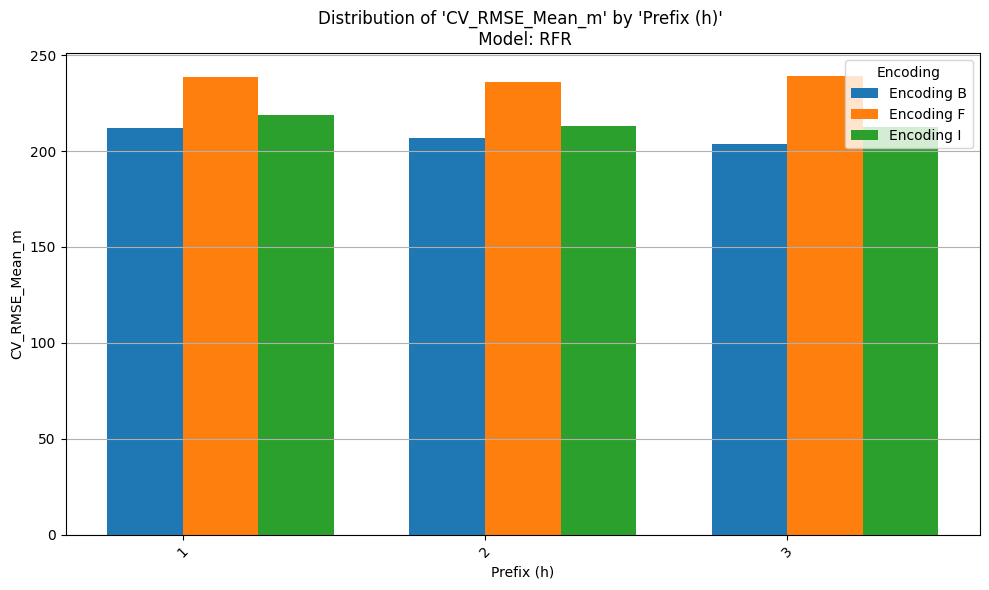

In [ ]:
if (len(df_ml_rfr) > 0):
    plot_custom_distribution_side_by_side(df_ml_rfr, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", "RFR")

In [ ]:
if (len(df_ml_xgr) > 0):
    plot_custom_distribution_side_by_side(df_ml_xgr, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", "XGR")

In [ ]:
print(">> Eplain the model with SHAP")
if rfr_regressor is not None:
    pass
    # explain_model_with_shap(rfr_regressor, X_train, X_test)

>> Eplain the model with SHAP


In [ ]:
print(">> Saving ML results")

path_out = Path(ml_dir) / "ML_ensemble_results.csv"
print("File:", path_out)
df_ml.to_csv(path_out, sep=";", index=False)

path_out = Path(ml_dir) / "ML_ensemble_results.xlsx"
print("File:", path_out)
df_ml.to_excel(path_out, index=False, sheet_name="ML_ensemble_results")

>> Saving ML results
File: data_ml/ML_ensemble_results.csv
File: data_ml/ML_ensemble_results.xlsx


In [ ]:
# program end
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()

End process: 2024-08-03 16:29:25
Time to finish: 0:56:30

*** PROGRAM END ***

